First, we will mount our Google Drive and ensure we are pulling the data in correctly.

In [2]:
#First Mount Google Drive to grab our data.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Then, Set Base Path Directory for the data.

base_dir = "/content/drive/MyDrive/ColabData/cats_vs_dogs_small"

import os

#Check subfolders
print("Contents of base directory:", os.listdir(base_dir))
print("Train subfolders:", os.listdir(os.path.join(base_dir, "train")))

Contents of base directory: ['train', 'test', 'validation']
Train subfolders: ['cats', 'dogs']


In [4]:
#The following will count the files in each class
def count_images(base_dir):
    for split in ['train', 'validation', 'test']:
        for label in ['cats', 'dogs']:
            folder = os.path.join(base_dir, split, label)
            count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{split.title()} - {label}: {count} images")

count_images(base_dir)

Train - cats: 1000 images
Train - dogs: 1000 images
Validation - cats: 500 images
Validation - dogs: 500 images
Test - cats: 500 images
Test - dogs: 500 images


Define Sampling Function

In [5]:
#This lets us randomly sample N images from each class folder

import random
import numpy as np
import pandas as pd

def sample_images(class_folder, label_name, sample_size, seed=42):
    """
    Randomly sample image file paths from one class folder.
    Returns a list of (filepath, label) tuples.
    """
    files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.seed(seed)
    sampled = random.sample(files, sample_size)
    return [(os.path.join(class_folder, f), label_name) for f in sampled]

In [6]:
#This builds DataFrames for each training sample size
def create_training_df(base_dir, sample_size, seed=42):
    cat_folder = os.path.join(base_dir, "train", "cats")
    dog_folder = os.path.join(base_dir, "train", "dogs")

    cat_samples = sample_images(cat_folder, "cat", sample_size, seed)
    dog_samples = sample_images(dog_folder, "dog", sample_size, seed)

    all_samples = cat_samples + dog_samples
    random.shuffle(all_samples)

    df = pd.DataFrame(all_samples, columns=["filename", "class"])
    return df

df_train_500 = create_training_df(base_dir, 500)
df_train_750 = create_training_df(base_dir, 750)
df_train_1000 = create_training_df(base_dir, 1000)

#Preview
print("500-sample set:", df_train_500.shape)
print("750-sample set:", df_train_750.shape)
print("1000-sample set:", df_train_1000.shape)
df_train_500.head()

500-sample set: (1000, 2)
750-sample set: (1500, 2)
1000-sample set: (2000, 2)


,filename,class
0,/content/drive/MyDrive/ColabData/cats_vs_dogs_...,dog
1,/content/drive/MyDrive/ColabData/cats_vs_dogs_...,dog
2,/content/drive/MyDrive/ColabData/cats_vs_dogs_...,dog
3,/content/drive/MyDrive/ColabData/cats_vs_dogs_...,cat
4,/content/drive/MyDrive/ColabData/cats_vs_dogs_...,cat


In [7]:
#Now we will create Keras ImageDataGenerators to load our sampled training sets (500, 750, 1000 images per class)
#We'll also create generators for validation and test sets, which are already organized into folders.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#First, define image data generators with data augmentation for training
#Data augmentation helps prevent overfitting by randomly transforming the training images
train_datagen = ImageDataGenerator(
    rescale=1./255,                  #Normalize pixel values (0-1)
    rotation_range=30,               #Random rotation
    width_shift_range=0.2,           #Random horizontal shift
    height_shift_range=0.2,          #Random vertical shift
    shear_range=0.2,                 #Shear transformation
    zoom_range=0.2,                  #random zoom
    horizontal_flip=True,            #Randomly flip images horizontally
    fill_mode='nearest'              #Fill in missing pixels after transformations
)


#For validation and test sets, we only rescale (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
#Now we will create image generators for our 3 training sample sizes
#These generators will load images and labels from the DataFrames we created earlier

train_generator_500 = train_datagen.flow_from_dataframe(
    df_train_500,                   #Our sampled 500-per-class training set
    x_col='filename',               #column with image file paths
    y_col='class',                  #column with labels (cat/dog)
    target_size=(150, 150),         #Resize all images to 150x150 pixels
    batch_size=32,                  #Process images in batches of 32
    class_mode='binary',            #we have 2 classes (cats vs. dogs)
    shuffle=True                    #Shuffle images each epoch
)

train_generator_750 = train_datagen.flow_from_dataframe(
    df_train_750,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

train_generator_1000 = train_datagen.flow_from_dataframe(
    df_train_1000,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 1000 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [9]:
#Now we will load our validation and test sets using flow_from_directory
#These folders are already organized into class subfolders (cats/ and dogs/)

val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

#Validation generator (used during training to monitor performance)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

#Test generator (used after training to evaluate final performance)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#Build and Train CNN From Scratch (500-sample)

In [10]:
#Now we will build a CNN (convolutional neural network) from scratch
#This model will be trained using 500 cat and 500 dog images (1000 total)

from tensorflow.keras import layers, models, optimizers

#Define a basic CNN architecture
model_scratch = models.Sequential([
    #First convolution layer: 32 filters of size 3x3 + ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),  # Downsample the feature map

    #Second convolution layer: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    #Third convolution layer: 128 filters
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    #Flatten the 3D feature maps into a 1D vector
    layers.Flatten(),

    #Dense (fully connected) layer with 512 neurons
    layers.Dense(512, activation='relu'),

    #Dropout helps reduce overfitting by randomly "dropping out" neurons during training
    layers.Dropout(0.5),

    #Output layer: sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
#Compile the model
#We use binary cross-entropy loss since this is a 2-class problem
#Accuracy is used as our performance metric

model_scratch.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
#Train the model using the 500-sample training generator
#We will validate performance after each epoch using the validation generator

history_scratch_500 = model_scratch.fit(
    train_generator_500,           #Training data (500 cats + 500 dogs)
    epochs=20,                     #Number of training iterations
    validation_data=val_generator  #Validation data (fixed set)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 343s 11s/step - accuracy: 0.5009 - loss: 0.7229 - val_accuracy: 0.5030 - val_loss: 0.6874
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.5290 - loss: 0.6873 - val_accuracy: 0.6020 - val_loss: 0.6880
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.5244 - loss: 0.6822 - val_accuracy: 0.5110 - val_loss: 0.7279
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.5737 - loss: 0.6759 - val_accuracy: 0.5810 - val_loss: 0.6610
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.5946 - loss: 0.6605 - val_accuracy: 0.5500 - val_loss: 0.7024
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - accuracy: 0.6293 - loss: 0.6446 - val_accuracy: 0.6540 - val_loss: 0.6280
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.6330 - loss: 0.6545 - val_accuracy: 0.6640 - val_loss: 0.6026
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.6182 - loss: 0.6493 - val_accur

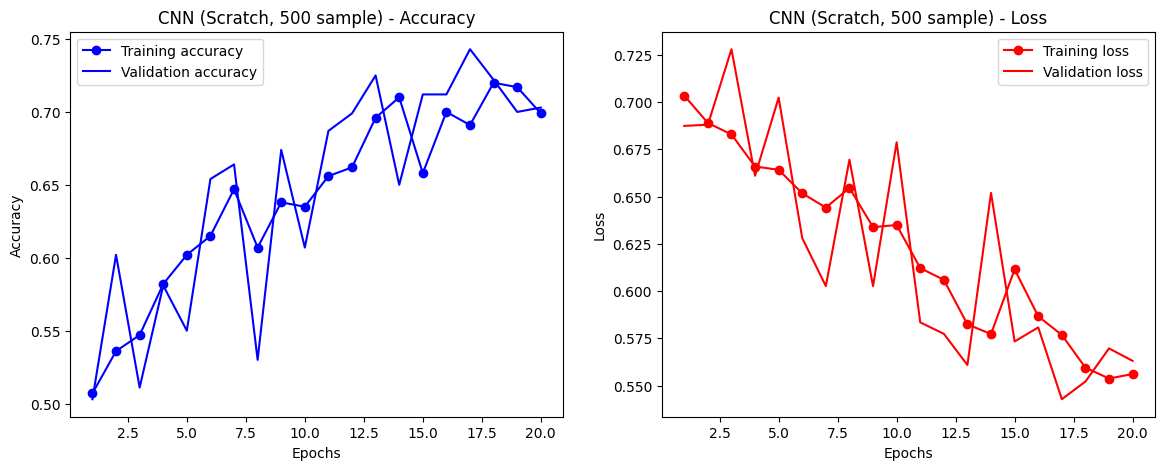

In [24]:
#Now we will plot the training and validation accuracy and loss over epochs
#This helps us visually understand model performance and signs of overfitting

import matplotlib.pyplot as plt

def plot_history(history, title='CNN (Scratch, 500 sample)'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    #Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

#Plot training history
plot_history(history_scratch_500)

This graph shows that both training and validation accuracy improved over the 20 epochs, with final validation accuracy reaching around 70%. While there was some fluctuation, especially early on, both curves generally trended upward, suggesting the model was learning. The loss curves show a consistent downward trajectory for both training and validation loss, indicating that the model was steadily reducing its prediction error and learning meaningful patterns from the limited 500-sample dataset.

In [17]:
#Get the final validation accuracy (last epoch)
val_acc = history_scratch_500.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {val_acc:.4f}")

Final Validation Accuracy: 0.7030


In [15]:
#Evaluate the trained model on the test data
test_loss, test_acc = model_scratch.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step - accuracy: 0.6687 - loss: 0.5988
Test Accuracy: 0.6780
Test Loss: 0.5930


#Build and Train CNN From Scratch (750-sample)

In [18]:
#Builds a fresh CNN model from scratch again (same architecture)
from tensorflow.keras import layers, models

model_scratch_750 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#Compiles the model
model_scratch_750.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
#Trains the model using the 750-sample generator and validation set
history_scratch_750 = model_scratch_750.fit(
    train_generator_750,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5041 - loss: 0.9137 - val_accuracy: 0.5830 - val_loss: 0.6922
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - accuracy: 0.5182 - loss: 0.6926 - val_accuracy: 0.5890 - val_loss: 0.6816
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.5459 - loss: 0.6861 - val_accuracy: 0.5660 - val_loss: 0.6796
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.5285 - loss: 0.6909 - val_accuracy: 0.5470 - val_loss: 0.6799
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.5472 - loss: 0.6837 - val_accuracy: 0.5780 - val_loss: 0.6715
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.5721 - loss: 0.6744 - val_accuracy: 0.5710 - val_loss: 0.6706
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.5810 - loss: 0.6712 - val_accuracy: 0.5230 - val_loss: 0.6807
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.5647 - loss: 0.6731 - val_accurac

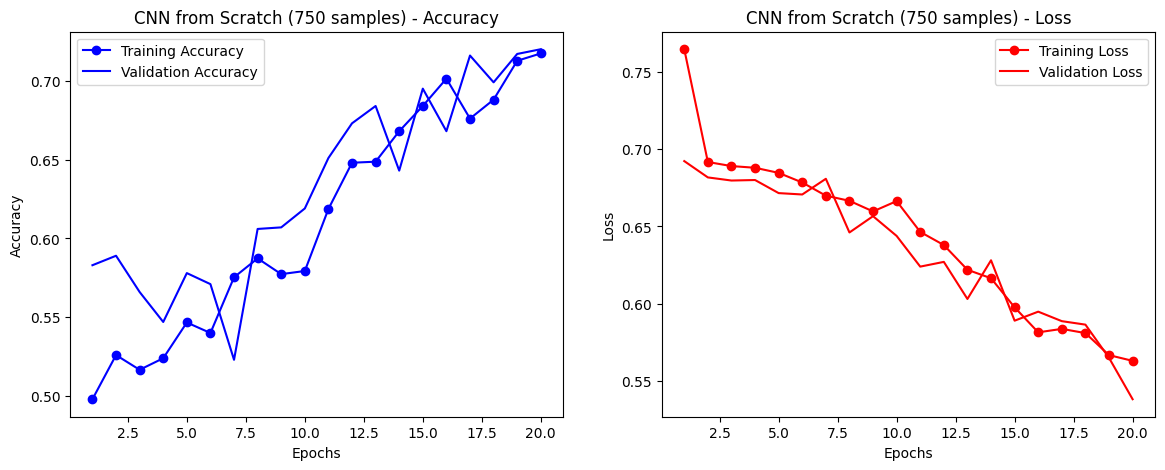

In [23]:
#This function plots accuracy and loss over each epoch for both training and validation sets just like we did with the 500 sample size
def plot_history(history, title='Training History'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    #Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

#Plot training history
plot_history(history_scratch_750, title="CNN from Scratch (750 samples)")

This graph shows how both training and validation accuracy steadily improved over 20 epochs using 750 images per class. The validation accuracy reached about 72%, closely tracking the training accuracy, which suggests the model generalized well without overfitting. The loss curves also steadily declined, further confirming stable learning and convergence.

In [21]:
#Get the final validation accuracy (last epoch)
val_acc_750 = history_scratch_750.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (750 samples): {val_acc_750:.4f}")

Final Validation Accuracy (750 samples): 0.7200


In [22]:
#Evaluate the trained model on the test data
test_loss_750, test_acc_750 = model_scratch_750.evaluate(test_generator)
print(f"Test Accuracy (750 samples): {test_acc_750:.4f}")
print(f"Test Loss (750 samples): {test_loss_750:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7174 - loss: 0.5375 
Test Accuracy (750 samples): 0.7060
Test Loss (750 samples): 0.5622


#Build and Train CNN From Scratch (1000-sample)

In [25]:
#Builds a fresh CNN model from scratch again (same architecture)
model_scratch_1000 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_scratch_1000.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
#Trains the model using the 1000-sample generator and validation set
history_scratch_1000 = model_scratch_1000.fit(
    train_generator_1000,
    epochs=20,
    validation_data=val_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5224 - loss: 0.8452 - val_accuracy: 0.5600 - val_loss: 0.6883
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.5533 - loss: 0.6895 - val_accuracy: 0.5780 - val_loss: 0.6764
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.5767 - loss: 0.6700 - val_accuracy: 0.5630 - val_loss: 0.6680
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.5748 - loss: 0.6627 - val_accuracy: 0.6470 - val_loss: 0.6311
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.6409 - loss: 0.6481 - val_accuracy: 0.6980 - val_loss: 0.5868
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.5946 - loss: 0.6513 - val_accuracy: 0.6320 - val_loss: 0.6497
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.6457 - loss: 0.6513 - val_accuracy: 0.6900 - val_loss: 0.5916
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.6610 - loss: 0.6279 - val_accurac

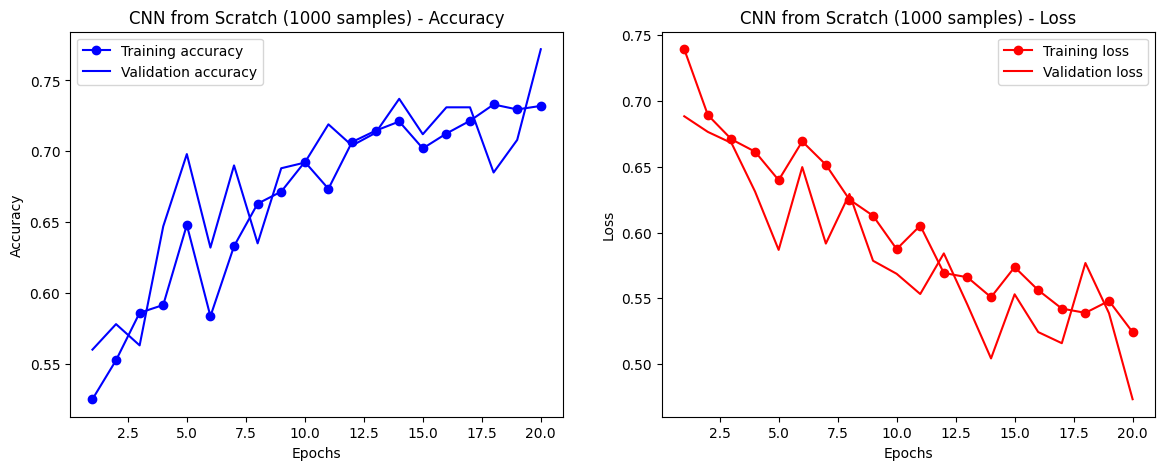

In [27]:
#Plot training history
plot_history(history_scratch_1000, title="CNN from Scratch (1000 samples)")

This graph shows steady improvement in both training and validation accuracy across 20 epochs, with final validation accuracy reaching approximately 73%. The training and validation curves remain closely aligned throughout, indicating the model generalized well without overfitting. The corresponding loss curves steadily decrease, ending at their lowest points by epoch 20. This suggests stable learning and continued optimization throughout training using the 1000-sample dataset.

In [28]:
val_acc_1000 = history_scratch_1000.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (1000 samples): {val_acc_1000:.4f}")

Final Validation Accuracy (1000 samples): 0.7720


In [29]:
test_loss_1000, test_acc_1000 = model_scratch_1000.evaluate(test_generator)
print(f"Test Accuracy (1000 samples): {test_acc_1000:.4f}")
print(f"Test Loss (1000 samples): {test_loss_1000:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7351 - loss: 0.5498 
Test Accuracy (1000 samples): 0.7450
Test Loss (1000 samples): 0.5306


As the training sample size increased, both validation and test accuracy consistently improved. The model trained on 500 samples achieved a validation accuracy of 70.3% and a test accuracy of 67.8%, while the 1000-sample model reached 77.2% validation accuracy and 74.5% test accuracy. Data augmentation techniques such as rotation, zoom, and horizontal flips were applied to the training images, which helped combat overfitting by introducing variability in the data. This effect became especially beneficial as the training set grew larger, allowing the model to generalize more effectively to unseen data. Overall, the results demonstrate a clear positive relationship between training sample size, regularization, and model performance.

#Pretrained Network (VGG16) with 500 samples

In [30]:
#Now we will use transfer learning by loading a pretrained VGG16 model.
#This model was originally trained on ImageNet and will help us extract high-level image features, allowing our classifier to perform better with limited training data.

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

#Loads the pretrained VGG16 (exclude top classifier, freeze convolutional layers)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False  #Freezes all convolutional layers

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
#Now we will add a custom classifier on top
model_vgg16_500 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  #Binary classification
])

In [32]:
#Compiles the model
model_vgg16_500.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
#Trains using the same 500-sample generator and validation set
history_vgg16_500 = model_vgg16_500.fit(
    train_generator_500,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.5642 - loss: 1.4159 - val_accuracy: 0.8500 - val_loss: 0.3969
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.7525 - loss: 0.4811 - val_accuracy: 0.8690 - val_loss: 0.3213
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.7930 - loss: 0.4188 - val_accuracy: 0.8830 - val_loss: 0.2907
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.8034 - loss: 0.4179 - val_accuracy: 0.8770 - val_loss: 0.2808
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.8205 - loss: 0.3954 - val_accuracy: 0.8770 - val_loss: 0.2988
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.8459 - loss: 0.3642 - val_accuracy: 0.8890 - val_loss: 0.2698
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.8211 - loss: 0.3639 - val_accuracy: 0.8840 - val_loss: 0.2685
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.8590 - loss: 0.3421 - val_accu

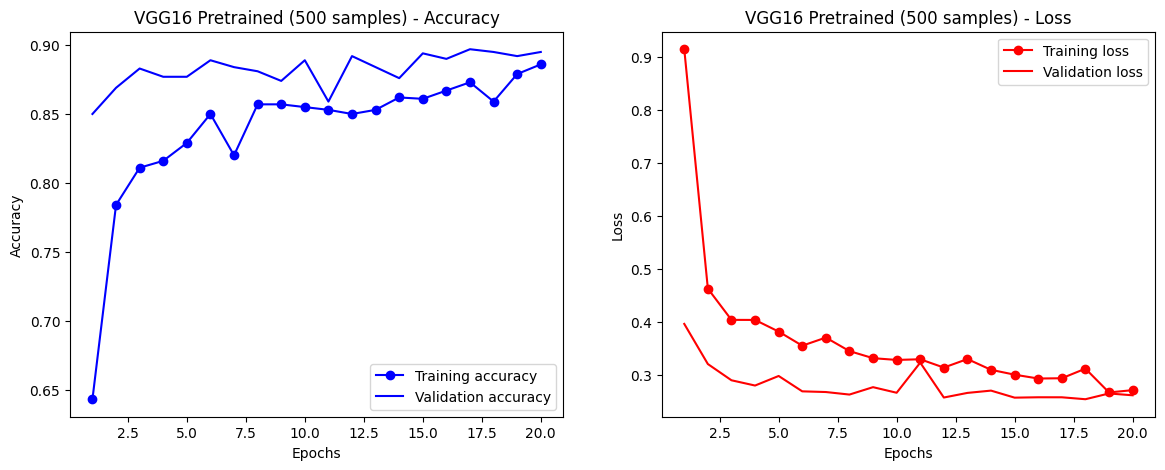

In [34]:
#Plot Accuracy & Loss
plot_history(history_vgg16_500, title="VGG16 Pretrained (500 samples)")

This graph shows that the VGG16 pretrained model achieved strong performance even with just 500 images per class. Validation accuracy quickly reached above 85% and remained consistently higher than training accuracy throughout the 20 epochs, suggesting good generalization. The training and validation loss curves both declined sharply, with validation loss stabilizing early and staying low. These results show that using a pretrained network allowed the model to leverage learned visual features from ImageNet, resulting in faster convergence and higher accuracy compared to training from scratch.

In [35]:
#Final validation accuracy
val_acc_vgg16_500 = history_vgg16_500.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (VGG16, 500 samples): {val_acc_vgg16_500:.4f}")


Final Validation Accuracy (VGG16, 500 samples): 0.8950


In [36]:
#Evaluate on test set
test_loss_vgg16_500, test_acc_vgg16_500 = model_vgg16_500.evaluate(test_generator)
print(f"Test Accuracy (VGG16, 500 samples): {test_acc_vgg16_500:.4f}")
print(f"Test Loss (VGG16, 500 samples): {test_loss_vgg16_500:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8751 - loss: 0.3032
Test Accuracy (VGG16, 500 samples): 0.8810
Test Loss (VGG16, 500 samples): 0.2874


#Pretrained Network (VGG16) with 750 samples

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

#Loads the VGG16 convolutional base with pretrained ImageNet weights
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

#Freezes all convolutional layers so we only train the new classifier
conv_base.trainable = False

#Builds the model top
model_vgg16_750 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#Compiles the model
model_vgg16_750.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
#Trains using the same 750-sample generator and validation set
history_vgg16_750 = model_vgg16_750.fit(
    train_generator_750,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.6351 - loss: 0.8889 - val_accuracy: 0.8790 - val_loss: 0.3312
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.7689 - loss: 0.4477 - val_accuracy: 0.8720 - val_loss: 0.2890
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.8232 - loss: 0.3829 - val_accuracy: 0.8900 - val_loss: 0.2758
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.8297 - loss: 0.3731 - val_accuracy: 0.8820 - val_loss: 0.2709
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.8411 - loss: 0.3416 - val_accuracy: 0.8810 - val_loss: 0.2713
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - accuracy: 0.8543 - loss: 0.3392 - val_accuracy: 0.8880 - val_loss: 0.2641
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.8300 - loss: 0.3656 - val_accuracy: 0.8880 - val_loss: 0.2586
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.8198 - loss: 0.3680 - val_accu

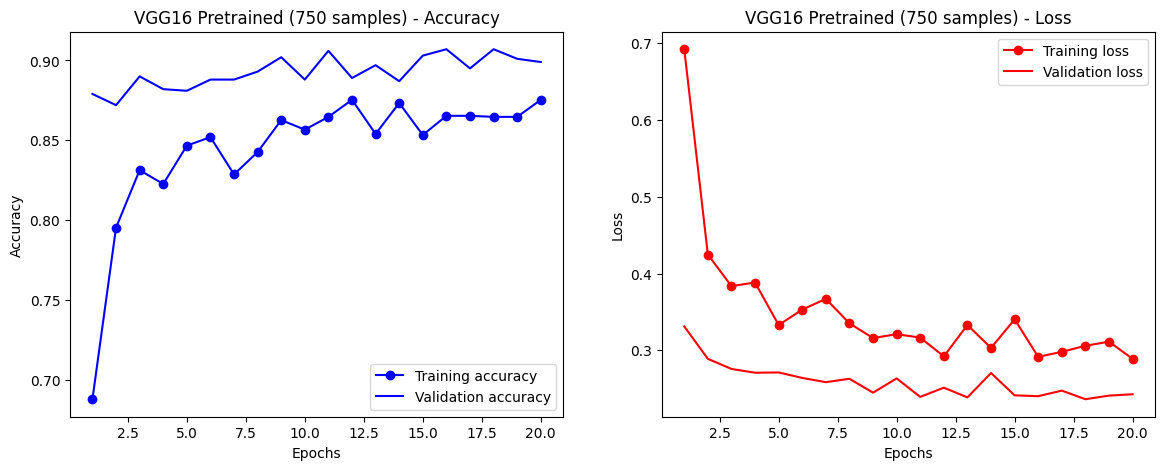

In [39]:
#Plot Accuracy & Loss
plot_history(history_vgg16_750, title="VGG16 Pretrained (750 samples)")

In [40]:
#Final validation accuracy
val_acc_vgg16_750 = history_vgg16_750.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (VGG16, 750 samples): {val_acc_vgg16_750:.4f}")

Final Validation Accuracy (VGG16, 750 samples): 0.8990


In [41]:
#Evaluate on test data
test_loss_vgg16_750, test_acc_vgg16_750 = model_vgg16_750.evaluate(test_generator)
print(f"Test Accuracy (VGG16, 750 samples): {test_acc_vgg16_750:.4f}")
print(f"Test Loss (VGG16, 750 samples): {test_loss_vgg16_750:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8794 - loss: 0.2706 
Test Accuracy (VGG16, 750 samples): 0.8830
Test Loss (VGG16, 750 samples): 0.2602


#Pretrained Network (VGG16) with 1000 samples

In [42]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False  #freeze base for feature extraction

#Builds the model top
model_vgg16_1000 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#Compiles the model
model_vgg16_1000.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
#Trains using the same 1000-sample generator and validation set
history_vgg16_1000 = model_vgg16_1000.fit(
    train_generator_1000,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - accuracy: 0.6832 - loss: 0.6848 - val_accuracy: 0.8730 - val_loss: 0.2966
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.8130 - loss: 0.4177 - val_accuracy: 0.8810 - val_loss: 0.2849
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8073 - loss: 0.3892 - val_accuracy: 0.8860 - val_loss: 0.2850
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.8505 - loss: 0.3644 - val_accuracy: 0.8910 - val_loss: 0.2671
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.8492 - loss: 0.3313 - val_accuracy: 0.8880 - val_loss: 0.2660
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.8420 - loss: 0.3586 - val_accuracy: 0.8940 - val_loss: 0.2645
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.8333 - loss: 0.3585 - val_accuracy: 0.8650 - val_loss: 0.2886
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.8689 - loss: 0.3317 - val_accu

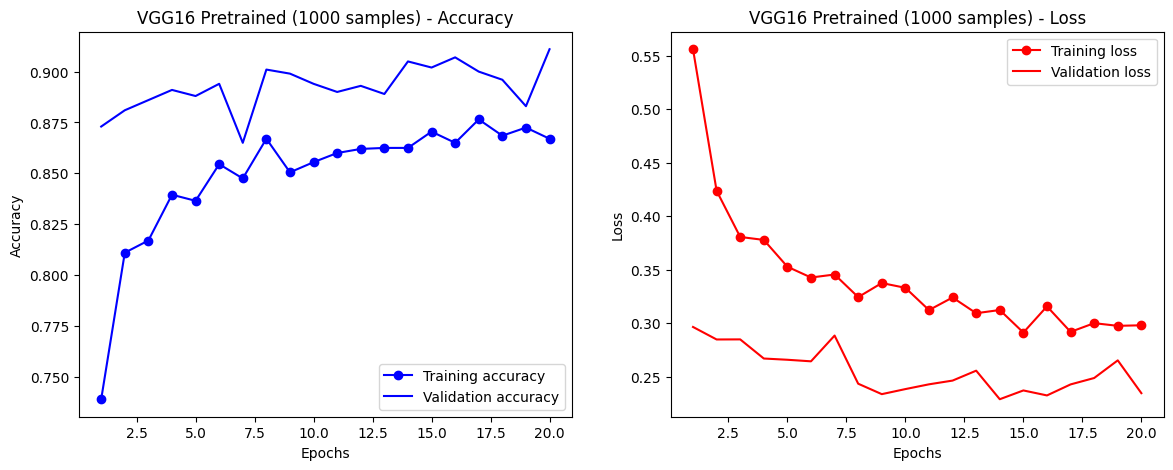

In [44]:
#Plot Accuracy & Loss
plot_history(history_vgg16_1000, title="VGG16 Pretrained (1000 samples)")

The pretrained VGG16 model trained on 1000 cat and dog images achieved consistently high accuracy and low loss across both the training and validation sets. Validation accuracy steadily improved and plateaued near 0.90, with training accuracy tracking slightly lower due to regularization (dropout). Loss curves indicate a gradual and stable decrease, with no signs of overfitting, suggesting that the model was able to generalize well despite the increased sample size.

In [45]:
#Final validation accuracy
val_acc_vgg16_1000 = history_vgg16_1000.history['val_accuracy'][-1]
print(f"Final Validation Accuracy (VGG16, 1000 samples): {val_acc_vgg16_1000:.4f}")

Final Validation Accuracy (VGG16, 1000 samples): 0.9110


In [46]:
#Evaluate on test data
test_loss_vgg16_1000, test_acc_vgg16_1000 = model_vgg16_1000.evaluate(test_generator)
print(f"Test Accuracy (VGG16, 1000 samples): {test_acc_vgg16_1000:.4f}")
print(f"Test Loss (VGG16, 1000 samples): {test_loss_vgg16_1000:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8990 - loss: 0.2458 
Test Accuracy (VGG16, 1000 samples): 0.9020
Test Loss (VGG16, 1000 samples): 0.2465


In this experiment, we leveraged a pretrained VGG16 convolutional base to perform binary classification on a cats vs. dogs dataset using progressively larger training sample sizes (500, 750, and 1000 total images, evenly split). The goal was to observe the effects of transfer learning, data augmentation, and sample size on model generalization and overfitting. By initializing with pretrained VGG16 weights (excluding top layers), the model learned to extract high-level image features right from the start. This significantly boosted early training performance even with just 500 samples. However, to combat potential overfitting (a common issue in small datasets), data augmentation techniques (random rotations, shifts, zooms, flips, etc.) were applied during training.

This augmentation helped simulate greater data diversity, which worked synergistically with the frozen convolution base. As we increased the number of training samples from 500 to 750 to1000, the model was able to further reduce validation loss and stabilize training, confirming that augmentation, along with more data together offer strong generalization.

#Plotting Validation and Test Accuracies: Scratch vs Pretrained Models

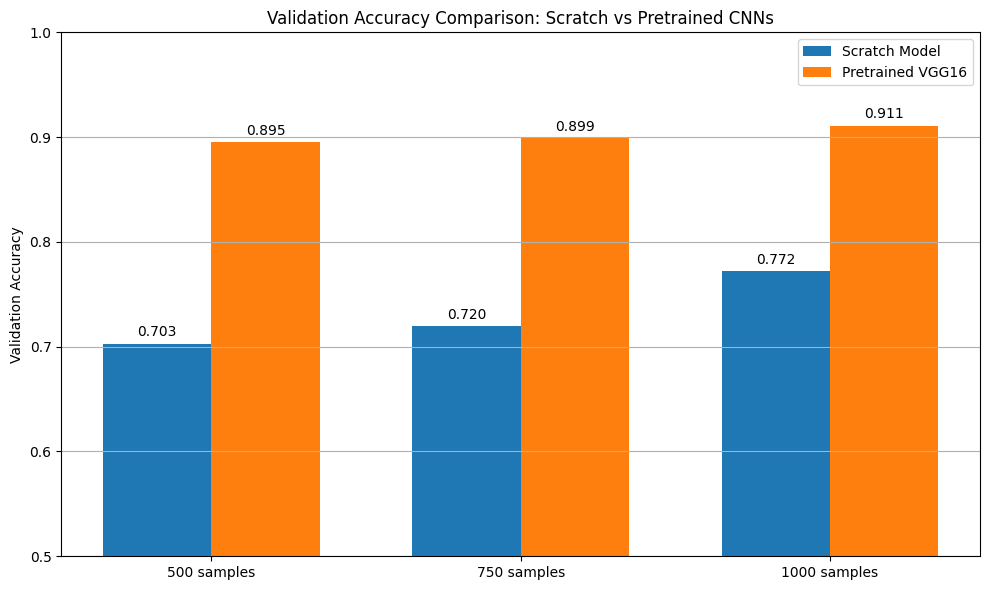

In [63]:
import matplotlib.pyplot as plt

#Sample sizes for x-axis
sample_sizes = [500, 750, 1000]

#Validation Accuracies
scratch_val_acc = [0.703, 0.720, 0.772]
pretrained_val_acc = [0.895, 0.899, 0.911]

#Width of the bars
width = 0.35

#Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, scratch_val_acc, width, label='Scratch Model')
bars2 = ax.bar(x + width/2, pretrained_val_acc, width, label='Pretrained VGG16')

#Labels and formatting
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy Comparison: Scratch vs Pretrained CNNs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.5, 1)
ax.legend()
ax.grid(True, axis='y')

#Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  #Offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

This bar chart compares the validation accuracy of CNN models trained from scratch vs. pretrained VGG16 models, across three different training sizes (500, 750, and 1000 samples). The pretrained models significantly outperform the scratch models at every level, even with limited training data. This demonstrates the effectiveness of transfer learning in improving generalization when data is scarce.

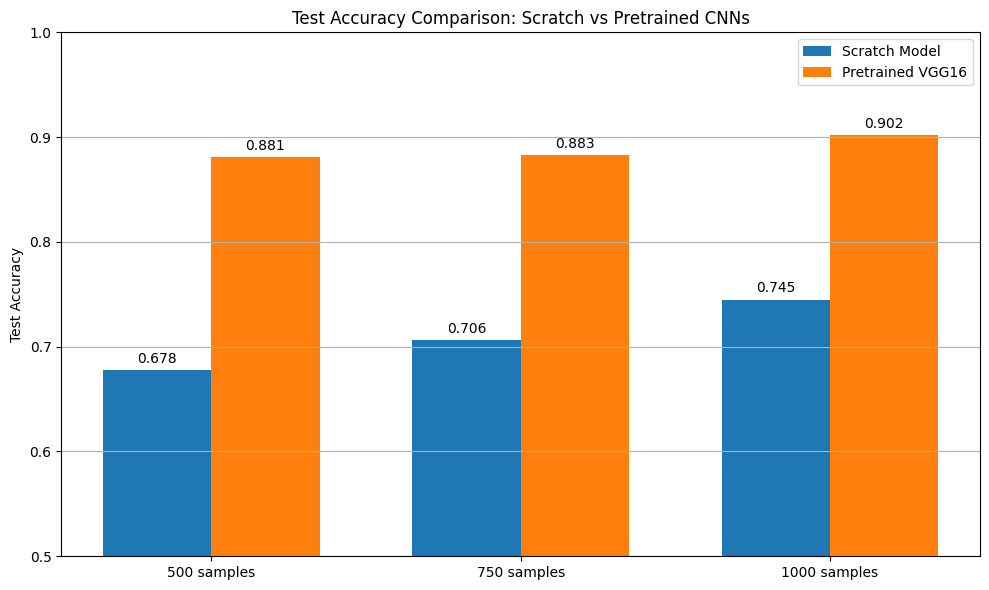

In [59]:
import matplotlib.pyplot as plt
import numpy as np

#Sample sizes
labels = ['500 samples', '750 samples', '1000 samples']
x = np.arange(len(labels))  #the label locations

#Test accuracies
scratch_accuracies = [0.678, 0.706, 0.745]
pretrained_accuracies = [0.881, 0.883, 0.902]

#Width of the bars
width = 0.35

#Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, scratch_accuracies, width, label='Scratch Model')
bars2 = ax.bar(x + width/2, pretrained_accuracies, width, label='Pretrained VGG16')

#Labels and formatting
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy Comparison: Scratch vs Pretrained CNNs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.5, 1)
ax.legend()
ax.grid(True, axis='y')

#Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  #Offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

This bar chart compares the test accuracy of CNNs trained from scratch versus pretrained VGG16 models using 500, 750, and 1000 training samples. Across all sample sizes, pretrained models consistently outperform scratch models. The pretrained models show more stable generalization to unseen data.

Based on the comparison of both validation and test accuracy across six models, the results strongly support the use of transfer learning with pretrained convolutional networks like VGG16. The pretrained models achieved consistently higher accuracy than scratch models, with gains ranging from 13–20 percentage points depending on the sample size. Even with just 500 training images, the pretrained model reached nearly 90% accuracy, demonstrating that feature reuse from large-scale datasets (like ImageNet) provides a powerful advantage when data is limited. These findings clearly indicate that leveraging pretrained CNNs is a more effective and data-efficient strategy than training from scratch in this binary classification task.

In [70]:
#Final Table showing the results of our models
#Defines the data
data = {
    'Model Type': ['Scratch Model', 'Scratch Model', 'Scratch Model',
                   'Pretrained VGG16', 'Pretrained VGG16', 'Pretrained VGG16'],
    'Samples': [500, 750, 1000, 500, 750, 1000],
    'Test Accuracy': [0.678, 0.706, 0.745, 0.881, 0.883, 0.902],
    'Test Loss': [0.5930, 0.5622, 0.5306, 0.2874, 0.2602, 0.2465]
}

#Creates a DataFrame
results_df = pd.DataFrame(data)

#Displays the table
results_df

,Model Type,Samples,Test Accuracy,Test Loss
0,Scratch Model,500,0.678,0.5930
1,Scratch Model,750,0.706,0.5622
2,Scratch Model,1000,0.745,0.5306
3,Pretrained VGG16,500,0.881,0.2874
4,Pretrained VGG16,750,0.883,0.2602
5,Pretrained VGG16,1000,0.902,0.2465
